<a href="https://colab.research.google.com/github/ajasja/RosettaCrashCourse/blob/main/notebooks/W01_Pyrosetta_Basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Install pyrosetta 
#@markdown Run cells by clicking on the little ▶ play icon to the left of each cell or by going to Runtime->Run all. 

#@markdown Enter the user name and password obtained from https://els2.comotion.uw.edu/product/pyrosetta

#@markdown The notebook must be connected to Google Drive. 

#@markdown Author: Ajasja Ljubetič (ajasja.ljubetic@gmail.com), inspired by https://nbviewer.org/github/RosettaCommons/PyRosetta.notebooks


#only needed for colabfold
!pip install pyrosettacolabsetup py3dmol git+https://github.com/RosettaCommons/pyrosetta_viewer3d.git
import pyrosettacolabsetup; pyrosettacolabsetup.install_pyrosetta()



In [ ]:
#@title Helper functions
def view_single(pose):
  import py3Dmol
  import pyrosetta.distributed.io as io
  view = py3Dmol.view(width=500, height=500)
  view.addModel(io.to_pdbstring(pose),'pdb')
  view.setStyle({'model': 0}, {"cartoon": True})
  view.addStyle({'model': 0}, {"stick": True})
  view.zoomTo()
  view.show()
  return None

def compare_poses(pose1, pose2):
  import py3Dmol
  import pyrosetta.distributed.io as io
  view = py3Dmol.view(width=500, height=500)
  view.addModel(io.to_pdbstring(pose1),'pdb')
  view.addModel(io.to_pdbstring(pose2),'pdb')
  view.setStyle({'model': 0}, {"cartoon": {'color': 'orange'}})
  view.addStyle({'model': 0}, {"stick": {'color': 'orange'}})
  view.setStyle({'model': 1}, {"cartoon": {'color': 'blue'}})
  view.addStyle({'model': 1}, {"stick": {'color': 'blue'}})
  view.zoomTo()
  view.show()
  return None  

Here we will get practice working with the `Pose` class in PyRosetta. We will load in a protein structure from PDB files, use the `Pose` class to learn about the geometry of the protein, make changes to this geometry, and visualize the changes easily with py3dmol and the new viewer3d.

In [ ]:
import pyrosetta; # import the pyrosetta package to access functionality
import pyrosetta.distributed.io as io
pyrosetta.init() # must be called before any other pyrosetta functions. Can accept command line flags

In [ ]:
# Create a pose from sequence. The structure made is extended and not very realistic
pose = pyrosetta.pose_from_sequence('TESTTHISEPICLIFE')
#get the number of residues
print(len(pose.residues))
#or
print(pose.total_residue())

#get the sequence 
print(pose.sequence())

view_single(pose)


In [ ]:
# Getting residues
# Residues are 1- index (start counting from 1)

res = pose.residue(2)
#Get name
print( res.name() )
#Get properties
print( res.is_charged() )


# Getting help & Code completion
The namespace is sometimes hard to nagivate. Code completition can be extremly helpful. The namespace (e.g. `pyrosetta.rosetta...`) is documented here: https://graylab.jhu.edu/PyRosetta.documentation/


In [ ]:
# Pressing `Ctrl + space` after dot will start code completition

#print some other properties
### BEGIN SOLUTION
res.is_
### END SOLUTION

In [ ]:
# Getting some limited help is also possible using ?
?pose.residue

# I usually use the C++ code as reference, but help is also available here: https://new.rosettacommons.org/docs/latest/Home

# Getting coordinates and structural data

## Distances

In [ ]:
import numpy as np #  numpy -- a packge for working with arrays. 

atom = res.atom('CA')
np.array(atom.xyz())

In [ ]:
# get length of CA-CB bond
vec = res.atom('CA').xyz()-res.atom('CB').xyz()
print(vec.norm())

## Dihedral angles

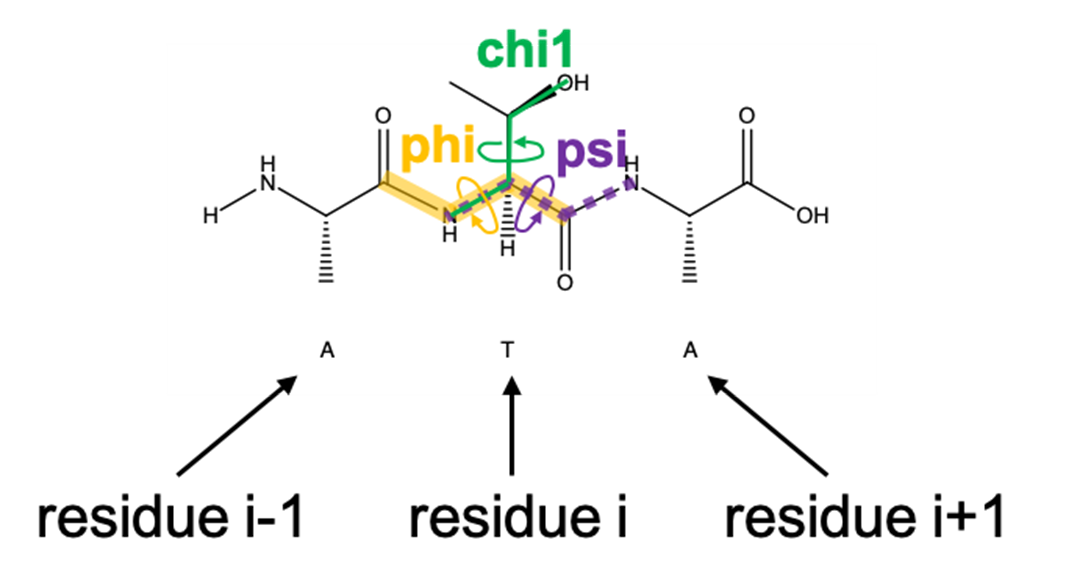

In [ ]:
# print dihedral angles
print("phi:", pose.phi(2))
print("psi:", pose.psi(2))
print("chi1:", pose.chi(chino=1, seqpos=2)) # this is an degrees
print()

#print all chi angles in degrees
res = pose.residue(2)
num_chi = len(res.chi_atoms())
for i in range(1, num_chi+1):
  print(f"Chi{i}: {res.chi(i):.2f} deg" )

## Changing dihedral angles

In [ ]:
pose.set_phi(seqpos=6, setting=90)
pose.set_phi(seqpos=15, setting=90)
view_single(pose)

In [ ]:
#save the pdb
pose.dump_pdb('test.pdb')

### Make an alphahelix from this pose

Hint: write a foor loop that sets each phi angle to -60 and each psi to -50.

In [ ]:
### BEGIN SOLUTION
from rosetta.core.scoring import CA_rmsd
pose_helix=pose.clone()
for i in range (1, pose_helix.total_residue()+1):
  pose.set_phi(seqpos=i,setting=-60)
  pose.set_psi(seqpos=i,setting=-50)

view_single(pose_helix)
### END SOLUTION

# Mutate a residue

In [ ]:
# it's possible to change one reside for another 
from pyrosetta.toolbox import mutate_residue

mutate_residue(pose, mutant_position=5, mutant_aa='K')
print(pose.sequence)
view_single(pose)

# Calculating RMSDs
Root square mean deviation is a useful metric when comparing two proteins structures.

In [ ]:
from  pyrosetta.rosetta.core.scoring import CA_rmsd
pose1 = pose.clone()
#poses are identical so RMSD is 0
print(CA_rmsd(pose, pose1))
#make a change to the pose -- RMSD is now nonzero
pose1.set_phi(5, 90)
print(CA_rmsd(pose, pose1))
compare_poses(pose, pose1)

# Loading a PDB structure

PDB structures can loaded into a pose using `pose_from_pdb`. Non-protein atoms can be removed using:

```python
from pyrosetta.toolbox import cleanATOM
cleanATOM("your_pdb.pdb")
```



In [ ]:
# download or upload your favorite PDB
!wget https://files.rcsb.org/download/1atp.pdb1

from pyrosetta.toolbox import cleanATOM
cleanATOM("1atp.pdb1") # will create 1atp.clean.pdb

## Task: Load the original pose and the cleaned pose and compare the number of residues

In [ ]:
# download or upload your favorite PDB
!wget https://files.rcsb.org/download/1atp.pdb1
### BEGIN SOLUTION
pose = pyrosetta.pose_from_pdb('/content/1atp.pdb1')
pose_clean = pyrosetta.pose_from_pdb('/content/1atp.clean.pdb')

print(f"Pose has {pose.total_residue()} residues")
print(f"Clean pose has {pose_clean.total_residue()} residues")
### END SOLUTION

The mapping between the pdb numbering and Rosetta numbering is contained in the `pdb_info()` object, which also contains chain IDs and labels.

In [ ]:
# Print pose numberingto pdb
print(pose.pdb_info().pose2pdb(1))
# PDB numbering to Pose numbering
print(pose.pdb_info().pdb2pose('E', 224))


## Task: Calculate the distance between the N and C terminal CA atoms.

In [ ]:
### BEGIN SOLUTION
N_res = pose.residue(1)
C_res = pose.residue(pose.total_residue())
dist_vec = C_res.atom('CA').xyz()-N_res.atom('CA').xyz()
dist_vec.norm()
### END SOLUTION

# Taks: Calculate all psi and phi angles

In [ ]:
### BEGIN SOLUTION
for i in range(1, pose_clean.total_residue()):
  # print(i)
  psi = pose_clean.psi(i)
  phi = pose_clean.phi(i)
  print(f'psi: {psi} and phi: {phi}')
### END SOLUTION

# Bonus task: plot ramachandran diagram

In [ ]:
### BEGIN SOLUTION
import matplotlib.pyplot as plt

psi_angles = []
phi_angles = []

for res in range(1, pose_clean.total_residue()+1):
  psi_angles.append(pose_clean.psi(res))
  phi_angles.append(pose_clean.phi(res))

f, ax = plt.subplots(1,1, figsize=(6,6))
ax.scatter(phi_angles, psi_angles, color="gray", alpha=0.2)
plt.title("Ramachandran diagram")
ax.set_xlabel("phi", fontsize=14)
ax.set_ylabel("psi", fontsize=14)
ax.set_xlim(-180,180)
ax.set_ylim(-180,180)
### END SOLUTION